In [1]:
import torch
import torch.nn as nn
from scipy.optimize import fmin_l_bfgs_b
import torch.nn.functional as F
import numpy as np
import logging
import matplotlib.pyplot as plt
from tqdm import tqdm 

C:\Users\Songwooseok\miniconda3\envs\test\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Mnist dataset

In [2]:
from torchvision import datasets,transforms
mnist_testset = datasets.MNIST('./data_mnist', 
                   train=False,
                   download=True, 
                   transform=transforms.Compose([transforms.ToTensor()]))
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=1,shuffle=True)

# Model

In [67]:
#Load pretrained weights
pretrained_model = "weights/lenet_mnist_model.pth"
use_cuda=True 

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        ## Ghir f training 
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #print(x.shape)
        x = self.conv1(x)
        #print(x.shape)
        x = F.max_pool2d(x, 2)
        #print(x.shape)
        x = F.relu(x)
        #print(x.shape)
        
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

# Init device 
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Init the network
model = Net().to(device)

# Load pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  False


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [68]:
x, y = mnist_testset[0]

In [70]:
model(x.unsqueeze(0))

tensor([[-2.0900, -0.2965,  1.8210,  1.0334, -1.3872, -2.5627, -6.0535,  5.4380,
         -0.7644,  1.0989]], grad_fn=<AddmmBackward0>)

In [40]:
params = []

for name, param in model.named_parameters():
    param = param.detach().cpu().numpy()
    if 'conv' in name and 'weight' in name:
        param = np.transpose(param, (2, 3, 1, 0))

    if 'fc' in name and 'weight' in name:
        param = param.T
    
    params.append(param)

(5, 5, 1, 10)
(5, 5, 10, 20)


In [45]:
import pickle

In [46]:
with open('./lenet5.pkl', 'wb') as f:
    pickle.dump(params, f)

In [47]:
with open('./lenet5.pkl', 'rb') as f:
    d = pickle.load(f)

In [57]:
x.shape

torch.Size([1, 28, 28])

In [53]:
model(x.unsqueeze(0))

tensor([[-2.0900, -0.2965,  1.8210,  1.0334, -1.3872, -2.5627, -6.0535,  5.4380,
         -0.7644,  1.0989]], grad_fn=<AddmmBackward0>)

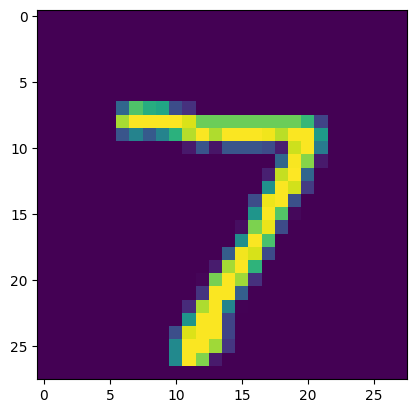

In [23]:
plt.imshow(x[0, :, :])
plt.show()

In [4]:
'''
import torch
from torchvision import datasets, transforms

# Define the transformation to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Get the first batch of training data and labels
x_train, y_train = next(iter(train_loader))

# Get the first batch of test data and labels
x_test, y_test = next(iter(test_loader))
'''

"\nimport torch\nfrom torchvision import datasets, transforms\n\n# Define the transformation to normalize the data\ntransform = transforms.Compose([\n    transforms.ToTensor(),\n    transforms.Normalize((0.1307,), (0.3081,))\n])\n\n# Load the MNIST dataset\ntrain_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)\ntest_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)\n\n# Create data loaders\ntrain_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)\ntest_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)\n\n# Get the first batch of training data and labels\nx_train, y_train = next(iter(train_loader))\n\n# Get the first batch of test data and labels\nx_test, y_test = next(iter(test_loader))\n"

In [5]:
class LBFGSAttack():
    """
    Class LBFGS attack L-BFGS-B to minimize the cross-entropy and the distance between the
    original and the adversary.
    """
    def __init__(self, model, device):
        self._adv = None  
        self.model = model
        self.device = device
        # Init bounds for lbfgs algo
        self.bounds = 0 , 1
        self._output = None

    def __call__(self, data,target, epsilon=0.01, steps=10):
        self.data = data.to(self.device)
        self.target = torch.tensor([target]).to(self.device) 
        # finding initial value for c        
        c = epsilon
        x0 = self.data.clone().cpu().numpy().flatten().astype(float)
        # Line search init
        for i in range(30):
            c = 2 * c
            # print('c={}'.format(c))
            is_adversary = self._lbfgsb(x0, c, steps)
            if is_adversary:
                # print('Successful')
                break
        if not is_adversary:
            # logging.info('Failed to init C ')
            return self._adv
        
        # binary search c
        c_low = 0
        c_high = c
        print(epsilon)
        while c_high - c_low >= epsilon:
            c_half = (c_low + c_high) / 2
            is_adversary = self._lbfgsb(x0, c_half, steps)
            if is_adversary:
                c_high = c_high-epsilon
            else:
                c_low = c_half

    def _loss(self, adv_x, c):
        """
        Get the loss and gradient wr to adversary
        params:
        adv_x: the candidate adversarial example
        c: parameter 'C' in the paper        
        return: 
        (loss, gradient)
        """
        adv = torch.from_numpy(adv_x.reshape(self.data.size())).float().to(self.device).requires_grad_(True)
    
        # cross_entropy
        output = self.model(adv)
        ce = F.cross_entropy(output, self.target)
        # L2 distance
        d =  torch.sum((self.data - adv) ** 2)
        #print(output.shape)
        #print(self.target.shape)
        # Loss 
        #print(ce.shape)
        loss = c * ce + d
        
        # gradient
        loss.backward()
        grad_ret = adv.grad.data.cpu().numpy().flatten().astype(float)
        
        loss = loss.data.cpu().numpy().flatten().astype(float)
        
        return loss, grad_ret

    def _lbfgsb(self, x0, c, maxiter):
        min_, max_ = self.bounds
        bounds = [(min_, max_)] * len(x0)
        approx_grad_eps = (max_ - min_) / 100.0
        #print(self._loss.shape)
        #print(type(x0))
        
#        print(bounds)
        #print(maxiter)
        #print(epsilon)
        
        x, f, d = fmin_l_bfgs_b(
            self._loss,
            x0,
            args=(c, ),
            bounds=bounds,
            maxiter=maxiter,
            epsilon=approx_grad_eps)
        if np.amax(x) > max_ or np.amin(x) < min_:
            x = np.clip(x, min_, max_)

        adv = torch.from_numpy(x.reshape(self.data.shape)).float().to(self.device)
        output = self.model(adv)
        adv_label = output.max(1, keepdim=True)[1]
        logging.info('target_label = {}, adv_label={}'.format(self.target, adv_label))
        # print('pre_label = {}, adv_label={}'.format(self.target, adv_label))
        self._adv = adv
        self._output = output
        return adv_label.item()== self.target.item()

# Attack

0.01
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])


Text(0.5, 1.0, 'Original image : 9, proba =1238.95%')

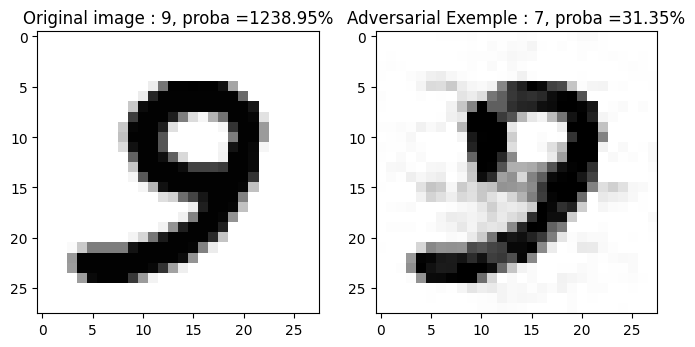

In [14]:
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=1,shuffle=True)

data , target = next(iter(test_loader))

lbfgs = LBFGSAttack(model,device)

lbfgs.__call__(data,torch.tensor(7),epsilon=0.01)

fig, ax = plt.subplots(1,2,figsize=(8,10))
adv = lbfgs._adv
print(adv.shape)
adv_numpy = adv.squeeze().detach().cpu().numpy()
print(adv.shape)
label_adv = model(adv).max(1, keepdim=True)[1]

proba_original = torch.exp(model(data)).max().item()*100
proba_adv = F.softmax(lbfgs._output,dim=1).max().item()*100

ax[1].imshow(adv_numpy,cmap='Greys')
ax[1].set_title("Adversarial Exemple : {}, proba ={}%".format(label_adv.item(),
                                                             round(proba_adv,2)))


data_numpy = data.squeeze().detach().cpu().numpy()
ax[0].imshow(data_numpy,cmap='Greys')
ax[0].set_title("Original image : {}, proba ={}%".format(target.item(),round(proba_original,2)))

In [11]:
target

tensor([0])

In [12]:
model(data)

tensor([[ 5.6346, -1.9302,  1.2014, -1.4811, -2.4150, -0.4058,  0.0146, -0.4631,
          0.3558, -0.3747]], grad_fn=<AddmmBackward0>)

In [98]:
def test_LBFGS_mnist(model, device, testloader, nb_exemples=1000, T=1):
    correct = 0
    adv_examples = []
    proba_adv = np.zeros(nb_exemples)
    proba_orig = np.zeros(nb_exemples)
    loop = tqdm(testloader)
    lbfgs = LBFGSAttack(model, device)
    for i, (data, target) in enumerate(loop):
        if i == nb_exemples:
            break
        data = data.to(device)
        target = target.to(target)
        # Get initial label
        output = model(data)
        output = F.log_softmax(output / T, dim=1)
        # index of the max log-probability
        init_pred = output.max(1, keepdim=True)[1]
        proba_orig[i] = torch.exp(output).max().item()*100
        if init_pred.item() != target.item():
            # Skip bad exemples in testdata
            continue
        n = torch.tensor(0)
        while n.item() == target.item():
            n = torch.randint(low=0, high=9, size=(1,))

        lbfgs(data, target=torch.randint(low=0, high=9, size=(1,)))
        adv = lbfgs._adv
        output = lbfgs._output
        proba_adv[i] = F.softmax(output / T, dim=1).max().item()*100
        final_pred = output.max(1, keepdim=True)[1]
        # Get probability
        # If same label changed
        if final_pred.item() == target.item():
            correct += 1
        else:
            if len(adv_examples) < 5:
                adversary = adv.squeeze().detach().cpu().numpy()
                original = data.squeeze().detach().cpu().numpy()
                adv_examples.append(
                    (original, adversary, init_pred, final_pred))

    final_acc = correct / nb_exemples  # Normally float(len(testloader))
    return final_acc, adv_examples, proba_orig, proba_adv


In [122]:
final_acc_lbfgs, adv_examples_lbfgs, proba_orig_lbfgs, proba_adv_lbfgs = test_LBFGS_mnist(model,
                                                                                          device,
                                                                                          test_loader,
                                                                                          nb_exemples=50)

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

0.01


  0%|                                                                             | 1/10000 [00:16<45:18:43, 16.31s/it]

0.01


  0%|                                                                             | 2/10000 [00:30<41:01:01, 14.77s/it]

0.01


  0%|                                                                             | 3/10000 [00:34<27:36:36,  9.94s/it]

0.01


  0%|                                                                             | 4/10000 [00:37<20:46:39,  7.48s/it]

0.01


  0%|                                                                             | 5/10000 [00:56<31:36:01, 11.38s/it]

0.01


  0%|                                                                             | 6/10000 [01:03<27:42:35,  9.98s/it]

0.01
0.01


  0%|                                                                             | 8/10000 [01:10<19:07:10,  6.89s/it]

0.01


  0%|                                                                             | 9/10000 [01:14<16:56:12,  6.10s/it]

0.01


  0%|                                                                            | 10/10000 [01:17<14:18:51,  5.16s/it]

0.01


  0%|                                                                            | 12/10000 [01:22<10:08:05,  3.65s/it]

0.01
0.01


  0%|                                                                            | 13/10000 [01:28<12:32:36,  4.52s/it]

0.01


  0%|                                                                             | 14/10000 [01:30<9:57:01,  3.59s/it]

0.01


  0%|                                                                            | 15/10000 [01:38<13:58:06,  5.04s/it]

0.01


  0%|                                                                            | 16/10000 [01:41<12:19:13,  4.44s/it]

0.01


  0%|▏                                                                           | 17/10000 [01:57<21:41:09,  7.82s/it]

0.01


  0%|▏                                                                           | 19/10000 [02:04<14:52:20,  5.36s/it]

0.01
0.01


  0%|▏                                                                           | 20/10000 [02:07<12:25:06,  4.48s/it]

0.01


  0%|▏                                                                           | 21/10000 [02:16<16:13:50,  5.86s/it]

0.01


  0%|▏                                                                           | 22/10000 [02:18<13:10:25,  4.75s/it]

0.01


  0%|▏                                                                           | 23/10000 [02:22<12:14:51,  4.42s/it]

0.01


  0%|▏                                                                           | 24/10000 [02:58<38:31:57, 13.91s/it]

0.01


  0%|▏                                                                           | 25/10000 [03:02<30:18:22, 10.94s/it]

0.01


  0%|▏                                                                           | 26/10000 [03:03<22:43:09,  8.20s/it]

0.01


  0%|▏                                                                           | 27/10000 [03:14<24:36:08,  8.88s/it]

0.01


  0%|▏                                                                           | 28/10000 [03:29<29:36:13, 10.69s/it]

0.01


  0%|▏                                                                           | 29/10000 [03:33<24:10:22,  8.73s/it]

0.01


  0%|▏                                                                           | 30/10000 [03:40<22:42:53,  8.20s/it]

0.01


  0%|▏                                                                           | 31/10000 [03:58<30:42:24, 11.09s/it]

0.01


  0%|▏                                                                           | 32/10000 [04:02<24:38:33,  8.90s/it]

0.01


  0%|▎                                                                           | 33/10000 [04:05<20:03:02,  7.24s/it]

0.01


  0%|▎                                                                           | 34/10000 [04:10<17:47:39,  6.43s/it]

0.01


  0%|▎                                                                           | 35/10000 [04:31<30:41:42, 11.09s/it]

0.01


  0%|▎                                                                           | 37/10000 [04:35<17:16:31,  6.24s/it]

0.01
0.01


  0%|▎                                                                            | 39/10000 [04:37<9:28:25,  3.42s/it]

0.01
0.01


  0%|▎                                                                            | 40/10000 [04:41<9:52:25,  3.57s/it]

0.01


  0%|▎                                                                            | 41/10000 [04:42<7:28:07,  2.70s/it]

0.01
0.01


  0%|▎                                                                           | 44/10000 [04:58<11:01:09,  3.98s/it]

0.01
0.01


  0%|▎                                                                            | 45/10000 [04:59<8:42:55,  3.15s/it]

0.01


  0%|▎                                                                            | 46/10000 [05:02<8:17:33,  3.00s/it]

0.01


  0%|▎                                                                           | 47/10000 [05:14<15:16:18,  5.52s/it]

0.01


  0%|▎                                                                           | 48/10000 [05:15<12:14:07,  4.43s/it]

0.01


  0%|▎                                                                           | 49/10000 [05:19<11:43:12,  4.24s/it]

0.01


  0%|▍                                                                           | 50/10000 [05:22<17:51:07,  6.46s/it]


In [36]:
# This attacks takes a very long time to generate adversaries, we pickled the results
import pickle
with open('weights/lbfgs.pkl','wb') as f :
    pickle.dump((final_acc_lbfgs, adv_examples_lbfgs, proba_orig_lbfgs, proba_adv_lbfgs),f)


 Accuracy for 100 exemples :  0.16


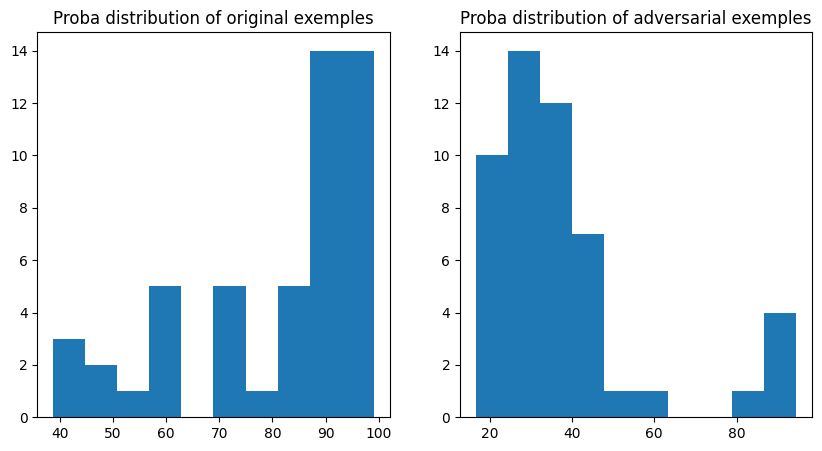

In [124]:
print(" Accuracy for 100 exemples : ",final_acc_lbfgs)

fig , axs = plt.subplots(1,2,figsize=(10,5))
axs[0].hist(proba_orig_lbfgs)
axs[0].set_title('Proba distribution of original exemples')

axs[1].hist(proba_adv_lbfgs)
axs[1].set_title('Proba distribution of adversarial exemples')

plt.show()

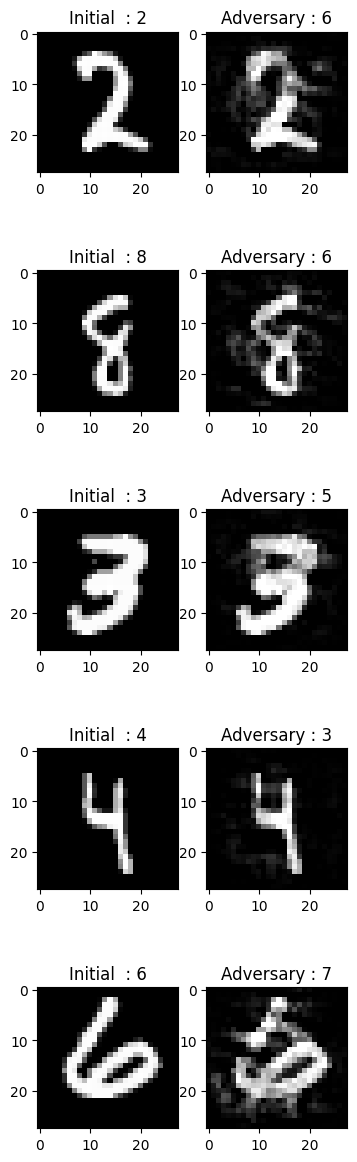

In [125]:
fig , axs = plt.subplots(ncols=2, nrows=len(adv_examples_lbfgs),figsize=(4,15))

for j in range(0,len(adv_examples_lbfgs)):
    original, adversary, init_pred , final_pred = adv_examples_lbfgs[j]
    axs[j,0].imshow(original,cmap='gray')
    axs[j,0].set_title('Initial  : {}'.format(init_pred.item()))
    axs[j,1].imshow(adversary,cmap='gray')
    axs[j,1].set_title('Adversary : {}'.format(final_pred.item()))
        
#plt.savefig('Results/Exemples LBFGS mnist.png')

In [126]:
len(adv_examples_lbfgs)

5